In [2]:
from nltk.tokenize import sent_tokenize, word_tokenize
import pandas as pd
import numpy as np
import markovify
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import *
from string import punctuation

In [3]:
STOPWORDS = stopwords.words('russian')

In [4]:
with open('voyna-i-mir.txt', encoding='utf-8') as f:
    original = [x for x in f.read().split('\n') if (x) and not (x.isspace())]

In [5]:
original = pd.DataFrame(original, columns=['text'])

In [6]:
original

,text
0,Лев Николаевич Толстой
1,Война и мир.
2,Том 1
3,Лев Николаевич Толстой
4,ВОЙНА И МИР
...,...
32539,(сноска 10) нитями богородицы.
32540,(сноска 11) Вы нездоровы?
32541,(сноска 12) Нет.
32542,(сноска 13) Общественный договор.


In [7]:
original['text'].apply(lambda x: x.isspace()).value_counts()

False    32544
Name: text, dtype: int64

In [8]:
original['class'] = 'original'

In [9]:
original = original.sample(frac=1, random_state=42)

In [14]:
original

,text,class
11544,"3до'ово, здо'ово, – закричал он всё тем же гол...",original
12736,"Наташа отошла подальше, чтоб осмотреться в трюмо.",original
32163,"Движение русского народа на восток, в Казань и...",original
9737,"Когда же это совершилось, и что такое совершил...",original
16765,Правда ли это?,original
...,...,...
29802,"Что ж, говорит, лежит, говорит, ихний-то, как ...",original
5390,С фрунтовым самодовольством он шел легко на му...,original
860,"- Ну-ка ты, силач, - обратился он к Пьеру.",original
15795,XII,original


In [15]:
train_sentences = original['text'].iloc[:22544]
len(train_sentences)

22544

In [16]:
test_sentences = original['text'].iloc[22544:]
len(test_sentences)

10000

In [17]:
train_model = markovify.NewlineText('\n'.join(train_sentences))

In [18]:
%%time

train_generated = []
for i in range(4500):
    train_generated.append(train_model.make_sentence())

Wall time: 18.4 s


In [19]:
train_generated = pd.DataFrame(train_generated, columns=['text'])

In [20]:
train_generated['class'] = 'generated'

In [21]:
train_generated

,text,class
0,"Когда он, это первое время, вспоминал о слышан...",generated
1,"- Благодарствуй, мой друг, он очень несчастлив...",generated
2,"– Не смотрите на то, что ее угощенье новинкой ...",generated
3,- А его уж бог простил ей то действительностью...,generated
4,"- Да, поди, поди, вели приготовить, - сказала ...",generated
...,...,...
4495,"– Марья Дмитриевна, указывая на своего завоева...",generated
4496,"Княжна Марья, по своему вкусу для невестки и д...",generated
4497,Но в этом предполагаемом браке.,generated
4498,"– Особа, очень высоко и семенить ногами.",generated


In [22]:
train_original = original.iloc[:22544].sample(4500, random_state=42)
train_original

,text,class
32329,"Узнав из опыта и рассуждения, что камень падае...",original
30365,Пьер засмеялся.,original
15119,– Изволили слышать о последнем событии на смот...,original
3980,"А по-нашему, не так.",original
13592,Ее особенно любила княжна Марья.,original
...,...,...
24513,"Москва сожжена жителями, это правда; но не тем...",original
27436,"Толь, который в этом сражении играл роль Вейро...",original
15527,"– Как же, нынче узнал, – сказал Шиншин, входив...",original
25940,"- Oui, sire, et elle est en cendres а l'heure ...",original


In [25]:
train = pd.concat((train_original, train_generated))
train = train.sample(frac=1, random_state=42)

In [26]:
train

,text,class
3440,"Когда Телянин кончил завтрак, он вынул из карм...",generated
25878,"На другой день, во время молебствия во дворце ...",original
22524,Но и этого он не может сделать.,original
9742,"И лицо его было страшно и жалко, особенно по б...",original
3912,"- сказал Болконский, оживляясь и при искусстве...",generated
...,...,...
1234,"Пелагеюшка остановилась недоверчиво, но в то ж...",generated
691,"И Пьер чувствовал, как со стуком приливает кро...",generated
890,"Другой, молодой мальчик, рекрут, белокурый и б...",generated
4537,Князь Андрей не только после своего путешестви...,original


In [28]:
X_train = train['text']
y_train = train['class']

In [29]:
model_2 = markovify.NewlineText('\n'.join(test_sentences), state_size=2)

In [30]:
%%time

test_generated_2 = []
for i in range(500):
    test_generated_2.append(model_2.make_sentence())

Wall time: 977 ms


In [31]:
test_generated_2 = pd.DataFrame(test_generated_2, columns=['text'])
test_generated_2['class'] = 'generated'
test_generated_2

,text,class
0,В то самое время как гусары становились на при...,generated
1,"- И те же графские висты и бостоны, за которым...",generated
2,"Она не думала об этом месяце плена, о тех нево...",generated
3,"Но не успел этого сделать, что ему казалось, п...",generated
4,Приехав в Москву каждый день; кроме того нужно...,generated
...,...,...
495,"- Но в Троицких воротах, несмотря на то, что о...",generated
496,"– Ну, да, это Кремль, да, - сказал Пьер, - но ...",generated
497,"На вид он был удивлен, когда, войдя в гостиную...",generated
498,Княжна Марья не могла этого сделать.,generated


In [32]:
test_original = original.iloc[22544:].sample(500, random_state=42)
test_original

,text,class
28047,"- Позови, позови его сюда!",original
20975,"- Ополченцы - те прямо надели чистые, бел...",original
6080,"Слышно было, как старый камергер в одном конце...",original
11546,"В лице его была та же бледная опухлость, котор...",original
23620,Остававшиеся в Москве люди шли по обоим бокам ...,original
...,...,...
30102,И страстную любовь итальянца Пьер теперь заслу...,original
8133,- Каково?,original
24041,"В это время первый кузнец поднялся с земли и, ...",original
17010,"Колебания о том, какой план из всех тех, котор...",original


In [34]:
test_2 = pd.concat((test_original, test_generated_2))
test_2 = test_2.sample(frac=1, random_state=42)
X_test_2 = test_2['text']
y_test_2 = test_2['class']

In [47]:
%%time

model_1 = markovify.NewlineText('\n'.join(test_sentences), state_size=1)

test_generated_1 = []
for i in range(500):
    test_generated_1.append(model_1.make_sentence(tries=10000))
    
test_generated_1 = pd.DataFrame(test_generated_1, columns=['text'])
test_generated_1['class'] = 'generated'
test_generated_1

test_1 = pd.concat((test_original, test_generated_1))
test_1 = test_1.sample(frac=1, random_state=42)
X_test_1 = test_1['text']
y_test_1 = test_1['class']

Wall time: 1.44 s


In [50]:
test_generated_1['text'].isna().value_counts()

False    500
Name: text, dtype: int64

In [51]:
%%time

model_3 = markovify.NewlineText('\n'.join(test_sentences), state_size=3)

test_generated_3 = []
for i in range(500):
    test_generated_3.append(model_3.make_sentence(tries=10000))
    
test_generated_3 = pd.DataFrame(test_generated_3, columns=['text'])
test_generated_3['class'] = 'generated'
test_generated_3

test_3 = pd.concat((test_original, test_generated_3))
test_3 = test_3.sample(frac=1, random_state=42)
X_test_3 = test_3['text']
y_test_3 = test_3['class']

Wall time: 2.47 s


In [52]:
test_generated_3['text'].isna().value_counts()

False    500
Name: text, dtype: int64

In [55]:
%%time

model_5 = markovify.NewlineText('\n'.join(test_sentences), state_size=5)

test_generated_5 = []
for i in range(500):
    test_generated_5.append(model_5.make_sentence(tries=100000))
    
test_generated_5 = pd.DataFrame(test_generated_5, columns=['text'])
test_generated_5['class'] = 'generated'
test_generated_5

test_5 = pd.concat((test_original, test_generated_5))
test_5 = test_5.sample(frac=1, random_state=42)
X_test_5 = test_5['text']
y_test_5 = test_5['class']

Wall time: 2min 22s


In [56]:
test_generated_5['text'].isna().value_counts()

False    500
Name: text, dtype: int64

In [87]:
train.to_csv('train.csv', index=False)
test_1.to_csv('test_1.csv', index=False)
test_2.to_csv('test_2.csv', index=False)
test_3.to_csv('test_3.csv', index=False)
test_5.to_csv('test_5.csv', index=False)

## Word grid

In [35]:
%%time

pipe = Pipeline([('vectorizer', 
                TfidfVectorizer(tokenizer=word_tokenize, stop_words=STOPWORDS)), 
               ('logistic',
                LogisticRegression()
                )
              ])

word_grid = GridSearchCV(
    pipe,
    param_grid={
        'vectorizer__ngram_range': ((1, 1), (1, 3), (1, 5), (2, 3), (2, 5)),
        'logistic__C': np.logspace(-3, 1, 5),
        'logistic__penalty': ['l1', 'l2']
    }
)

word_grid.fit(X_train, y_train)

c:\program files\python37\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
c:\program files\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\program files\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\program files\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\program files\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be chang

c:\program files\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\program files\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\program files\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\program files\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\program files\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to sile

c:\program files\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\program files\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\program files\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\program files\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\program files\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to sile

c:\program files\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\program files\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\program files\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\program files\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\program files\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to sile

c:\program files\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Wall time: 11min 23s


c:\program files\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('vectorizer',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                               

In [38]:
word_grid.best_params_

{'logistic__C': 1.0,
 'logistic__penalty': 'l1',
 'vectorizer__ngram_range': (1, 3)}

In [36]:
print('Train:')
print(classification_report(y_train, word_grid.predict(X_train)))
print('Test_2:')
print(classification_report(y_test_2, word_grid.predict(X_test_2)))

Train:
              precision    recall  f1-score   support

   generated       0.59      0.78      0.67      4500
    original       0.67      0.46      0.55      4500

    accuracy                           0.62      9000
   macro avg       0.63      0.62      0.61      9000
weighted avg       0.63      0.62      0.61      9000

Test_2:
              precision    recall  f1-score   support

   generated       0.61      0.81      0.69       500
    original       0.71      0.47      0.57       500

    accuracy                           0.64      1000
   macro avg       0.66      0.64      0.63      1000
weighted avg       0.66      0.64      0.63      1000



In [57]:
print('Test_1:')
print(classification_report(y_test_1, word_grid.predict(X_test_1)))

Test_1:
              precision    recall  f1-score   support

   generated       0.55      0.64      0.59       500
    original       0.57      0.47      0.52       500

    accuracy                           0.56      1000
   macro avg       0.56      0.56      0.55      1000
weighted avg       0.56      0.56      0.55      1000



In [58]:
print('Test_3:')
print(classification_report(y_test_3, word_grid.predict(X_test_3)))

Test_3:
              precision    recall  f1-score   support

   generated       0.63      0.90      0.74       500
    original       0.83      0.47      0.60       500

    accuracy                           0.69      1000
   macro avg       0.73      0.69      0.67      1000
weighted avg       0.73      0.69      0.67      1000



In [59]:
print('Test_5:')
print(classification_report(y_test_5, word_grid.predict(X_test_5)))

Test_5:
              precision    recall  f1-score   support

   generated       0.63      0.91      0.75       500
    original       0.85      0.47      0.61       500

    accuracy                           0.69      1000
   macro avg       0.74      0.69      0.68      1000
weighted avg       0.74      0.69      0.68      1000



## Char grid

In [39]:
%%time

pipe = Pipeline([('vectorizer', 
                TfidfVectorizer(analyzer='char', ngram_range=())), 
               ('SVM',
                LinearSVC()
                )
              ])

char_grid = GridSearchCV(
    pipe,
    param_grid={
        'vectorizer__ngram_range': ((1, 1), (1, 3), (1, 5), (2, 3), (2, 5), (3, 5), (3, 7), (5, 7), (5, 10)),
        'SVM__C': np.logspace(-3, 1, 5)
    }
)

char_grid.fit(X_train, y_train)

c:\program files\python37\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Wall time: 6min 33s


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('vectorizer',
                                        TfidfVectorizer(analyzer='char',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(),
                                   

In [40]:
char_grid.best_params_

{'SVM__C': 10.0, 'vectorizer__ngram_range': (1, 1)}

In [41]:
print('Train:')
print(classification_report(y_train, char_grid.predict(X_train)))
print('Test_2:')
print(classification_report(y_test_2, char_grid.predict(X_test_2)))

Train:
              precision    recall  f1-score   support

   generated       0.62      0.82      0.70      4500
    original       0.73      0.50      0.59      4500

    accuracy                           0.66      9000
   macro avg       0.68      0.66      0.65      9000
weighted avg       0.68      0.66      0.65      9000

Test_2:
              precision    recall  f1-score   support

   generated       0.62      0.85      0.72       500
    original       0.77      0.48      0.59       500

    accuracy                           0.67      1000
   macro avg       0.69      0.67      0.66      1000
weighted avg       0.69      0.67      0.66      1000



In [61]:
print('Test_1:')
print(classification_report(y_test_1, char_grid.predict(X_test_1)))

Test_1:
              precision    recall  f1-score   support

   generated       0.56      0.67      0.61       500
    original       0.60      0.48      0.53       500

    accuracy                           0.58      1000
   macro avg       0.58      0.58      0.57      1000
weighted avg       0.58      0.58      0.57      1000



In [62]:
print('Test_3:')
print(classification_report(y_test_3, char_grid.predict(X_test_3)))

Test_3:
              precision    recall  f1-score   support

   generated       0.64      0.92      0.75       500
    original       0.85      0.48      0.62       500

    accuracy                           0.70      1000
   macro avg       0.75      0.70      0.68      1000
weighted avg       0.75      0.70      0.68      1000



In [63]:
print('Test_5:')
print(classification_report(y_test_5, char_grid.predict(X_test_5)))

Test_5:
              precision    recall  f1-score   support

   generated       0.66      1.00      0.79       500
    original       1.00      0.48      0.65       500

    accuracy                           0.74      1000
   macro avg       0.83      0.74      0.72      1000
weighted avg       0.83      0.74      0.72      1000



## User char

In [42]:
%%time

user_char = Pipeline([('vectorizer', 
                TfidfVectorizer(analyzer='char', ngram_range=(1, 1))), 
               ('SVM',
                LinearSVC(C=0.1)
                )
              ])

user_char.fit(X_train, y_train)

Wall time: 239 ms


Pipeline(memory=None,
         steps=[('vectorizer',
                 TfidfVectorizer(analyzer='char', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('SVM',
                 LinearSVC(C=0.1, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
          

In [43]:
print('Train:')
print(classification_report(y_train, user_char.predict(X_train)))
print('Test_2:')
print(classification_report(y_test_2, user_char.predict(X_test_2)))

Train:
              precision    recall  f1-score   support

   generated       0.61      0.80      0.70      4500
    original       0.72      0.49      0.58      4500

    accuracy                           0.65      9000
   macro avg       0.66      0.65      0.64      9000
weighted avg       0.66      0.65      0.64      9000

Test_2:
              precision    recall  f1-score   support

   generated       0.61      0.84      0.71       500
    original       0.75      0.46      0.57       500

    accuracy                           0.65      1000
   macro avg       0.68      0.65      0.64      1000
weighted avg       0.68      0.65      0.64      1000



In [64]:
print('Test_1:')
print(classification_report(y_test_1, user_char.predict(X_test_1)))

Test_1:
              precision    recall  f1-score   support

   generated       0.55      0.67      0.61       500
    original       0.58      0.46      0.52       500

    accuracy                           0.57      1000
   macro avg       0.57      0.57      0.56      1000
weighted avg       0.57      0.57      0.56      1000



In [65]:
print('Test_3:')
print(classification_report(y_test_3, user_char.predict(X_test_3)))

Test_3:
              precision    recall  f1-score   support

   generated       0.63      0.91      0.75       500
    original       0.84      0.46      0.60       500

    accuracy                           0.69      1000
   macro avg       0.74      0.69      0.67      1000
weighted avg       0.74      0.69      0.67      1000



In [66]:
print('Test_5:')
print(classification_report(y_test_5, user_char.predict(X_test_5)))

Test_5:
              precision    recall  f1-score   support

   generated       0.63      0.91      0.75       500
    original       0.84      0.46      0.60       500

    accuracy                           0.69      1000
   macro avg       0.74      0.69      0.67      1000
weighted avg       0.74      0.69      0.67      1000



## Word N-gram grid,  no stopwords

In [67]:
%%time

pipe = Pipeline([('vectorizer', 
                TfidfVectorizer(tokenizer=word_tokenize)), 
               ('logistic',
                LogisticRegression()
                )
              ])

ngram_grid = GridSearchCV(
    pipe,
    param_grid={
        'vectorizer__ngram_range': ((3, 3), (4, 4), (5, 5)),
        'logistic__C': np.logspace(-3, 1, 5),
        'logistic__penalty': ['l1', 'l2']
    }
)

ngram_grid.fit(X_train, y_train)

c:\program files\python37\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
c:\program files\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\program files\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\program files\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\program files\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be chang

c:\program files\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\program files\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\program files\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\program files\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\program files\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to sile

c:\program files\python37\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\program files\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\program files\python37\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\program files\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\program files\python37\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of itera

Wall time: 13min 30s


c:\program files\python37\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('vectorizer',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                               

In [68]:
ngram_grid.best_params_

{'logistic__C': 10.0,
 'logistic__penalty': 'l1',
 'vectorizer__ngram_range': (3, 3)}

In [70]:
print('Train:')
print(classification_report(y_train, ngram_grid.predict(X_train)))
print('Test_1:')
print(classification_report(y_test_1, ngram_grid.predict(X_test_1)))
print('Test_2:')
print(classification_report(y_test_2, ngram_grid.predict(X_test_2)))
print('Test_3:')
print(classification_report(y_test_3, ngram_grid.predict(X_test_3)))
print('Test_5:')
print(classification_report(y_test_5, ngram_grid.predict(X_test_5)))

Train:
              precision    recall  f1-score   support

   generated       0.99      0.99      0.99      4500
    original       0.99      0.99      0.99      4500

    accuracy                           0.99      9000
   macro avg       0.99      0.99      0.99      9000
weighted avg       0.99      0.99      0.99      9000

Test_1:
              precision    recall  f1-score   support

   generated       0.49      0.23      0.32       500
    original       0.50      0.76      0.60       500

    accuracy                           0.50      1000
   macro avg       0.49      0.50      0.46      1000
weighted avg       0.49      0.50      0.46      1000

Test_2:
              precision    recall  f1-score   support

   generated       0.62      0.39      0.48       500
    original       0.55      0.76      0.64       500

    accuracy                           0.57      1000
   macro avg       0.59      0.57      0.56      1000
weighted avg       0.59      0.57      0.56      10

## User N-gram, no stopwords

In [84]:
%%time

user_ngram = Pipeline([('vectorizer', 
                TfidfVectorizer(tokenizer=word_tokenize, ngram_range=(5, 5))), 
               ('SVM',
                LinearSVC(C=0.1)
                )
              ])

user_ngram.fit(X_train, y_train)

Wall time: 1.42 s


Pipeline(memory=None,
         steps=[('vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(5, 5), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<function word_tokenize at 0x00000188C10E7378>,
                                 use_idf=True, vocabulary=None)),
                ('SVM',
                 LinearSVC(C=0.1, class_weight=None, dual=True,
                           fit_inter

In [85]:
print('Train:')
print(classification_report(y_train, user_ngram.predict(X_train)))
print('Test_1:')
print(classification_report(y_test_1, user_ngram.predict(X_test_1)))
print('Test_2:')
print(classification_report(y_test_2, user_ngram.predict(X_test_2)))
print('Test_3:')
print(classification_report(y_test_3, user_ngram.predict(X_test_3)))
print('Test_5:')
print(classification_report(y_test_5, user_ngram.predict(X_test_5)))

Train:
              precision    recall  f1-score   support

   generated       1.00      1.00      1.00      4500
    original       1.00      1.00      1.00      4500

    accuracy                           1.00      9000
   macro avg       1.00      1.00      1.00      9000
weighted avg       1.00      1.00      1.00      9000

Test_1:
              precision    recall  f1-score   support

   generated       0.39      0.03      0.05       500
    original       0.50      0.96      0.65       500

    accuracy                           0.49      1000
   macro avg       0.44      0.49      0.35      1000
weighted avg       0.44      0.49      0.35      1000

Test_2:
              precision    recall  f1-score   support

   generated       0.59      0.06      0.12       500
    original       0.51      0.96      0.66       500

    accuracy                           0.51      1000
   macro avg       0.55      0.51      0.39      1000
weighted avg       0.55      0.51      0.39      10

# Visualisation

In [3]:
import matplotlib.pyplot as plt

%matplotlib inline

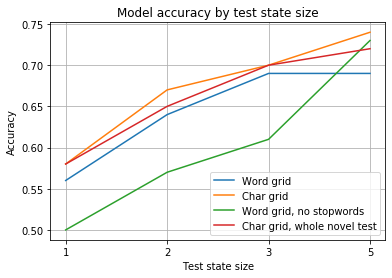

In [21]:
fig = plt.figure()
ax = plt.axes()

ax.set_xticklabels(['1', '2', '3', '5'])
ax.plot(['1', '2', '3', '5'], [0.56, 0.64, 0.69, 0.69], label='Word grid')
ax.plot(['1', '2', '3', '5'], [0.58, 0.67, 0.70, 0.74], label='Char grid')
ax.plot(['1', '2', '3', '5'], [0.50, 0.57, 0.61, 0.73], label='Word grid, no stopwords')
ax.plot(['1', '2', '3', '5'], [0.58, 0.65, 0.7, 0.72], label='Char grid, whole novel test')
ax.legend()
ax.set(
    xlabel='Test state size',
    ylabel='Accuracy',
    title='Model accuracy by test state size'
)
ax.grid()
plt.show()
fig.savefig('model_accuracy_by_test_state_size.png')